In [ ]:
# Заголовок первого уровня
## Заголовок второго уровня
*Курсивный текст* и **жирный текст**.

Формула: $$E = mc^2$$

In [1]:
import rdkit
print(rdkit.__version__)

2025.03.6


Исходные данные:
  Alkane_Name SMILES  Refractive_Index_Exp
0     Methane      C                 1.000
1      Ethane     CC                 1.001
2     Propane    CCC                 1.002
3      Butane   CCCC                 1.003
4     Pentane  CCCCC                 1.004
--------------------------------------------------

Данные с дескрипторами:
  Alkane_Name SMILES  Refractive_Index_Exp  \
0     Methane      C                 1.000   
1      Ethane     CC                 1.001   
2     Propane    CCC                 1.002   
3      Butane   CCCC                 1.003   
4     Pentane  CCCCC                 1.004   

                                                 Mol  <lambda>  <lambda>  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001E6666...    16.043         0   
1  <rdkit.Chem.rdchem.Mol object at 0x000001E6666...    30.070         0   
2  <rdkit.Chem.rdchem.Mol object at 0x000001E6666...    44.097         0   
3  <rdkit.Chem.rdchem.Mol object at 0x000001E6686...    58.124      

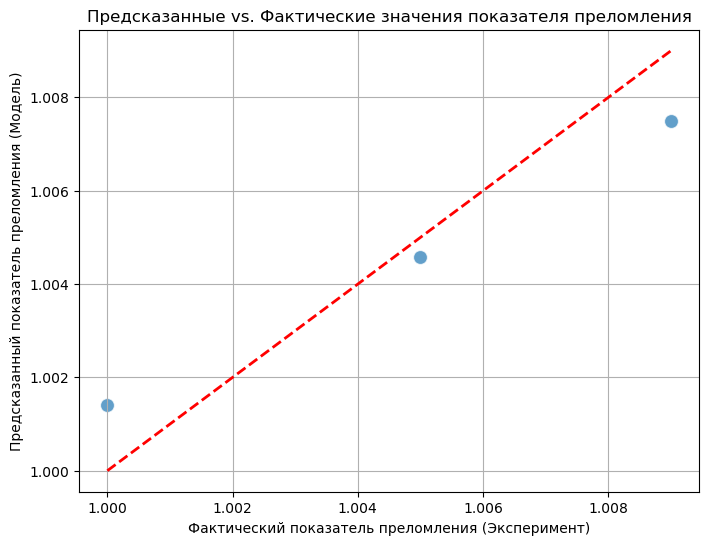

--------------------------------------------------

Важность дескрипторов:
                Feature  Importance
19             <lambda>    0.081441
8              <lambda>    0.071550
13  MaxAbsPartialCharge    0.061096
6              <lambda>    0.060451
12             BalabanJ    0.059434
7              <lambda>    0.057274
2              <lambda>    0.057126
0              <lambda>    0.056236
9              <lambda>    0.055929
15             <lambda>    0.052281
16             <lambda>    0.049299
3              <lambda>    0.046984
18             <lambda>    0.046690
10             <lambda>    0.043149
20             <lambda>    0.042143
1              <lambda>    0.036610
4              <lambda>    0.035020
11             <lambda>    0.032399
17             <lambda>    0.026178
14  MinAbsPartialCharge    0.023296
5              <lambda>    0.005415


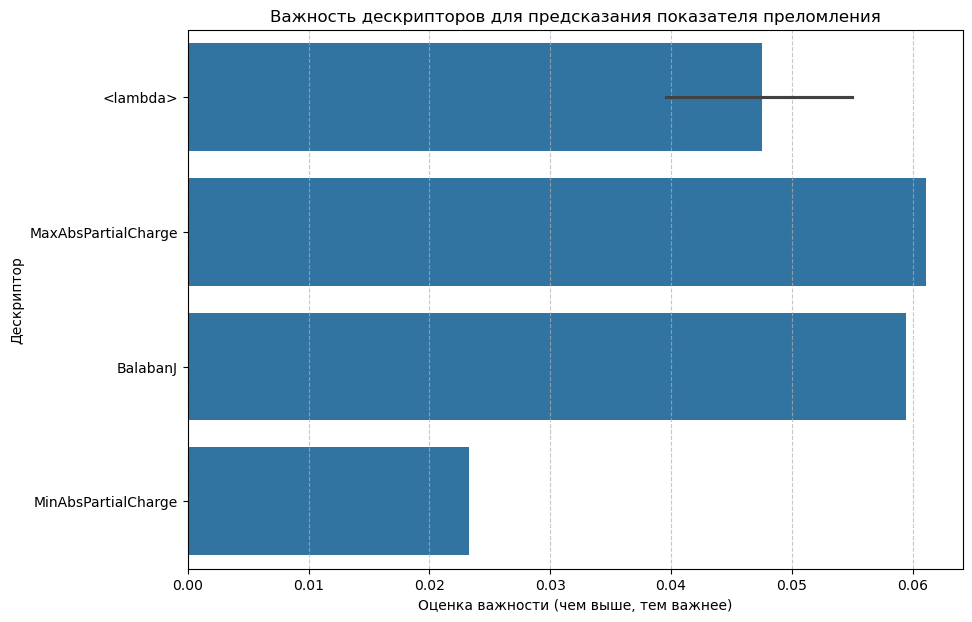

--------------------------------------------------


In [8]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem # AllChem для генерации 2D-координат, если понадобится

# --------------------------------------------------------------------------------
# ШАГ 1.1: Создание или загрузка исходных данных
# Вам нужно собрать таблицу, где будет SMILES (или название) молекулы и её показатель преломления.
# Пример данных для алканов (гипотетические значения для иллюстрации):

data = {
    'Alkane_Name': ['Methane', 'Ethane', 'Propane', 'Butane', 'Pentane', 'Hexane', 'Heptane', 'Octane', 'Nonane', 'Decane', 'Бутан_изо'],
    'SMILES': ['C', 'CC', 'CCC', 'CCCC', 'CCCCC', 'CCCCCC', 'CCCCCCC', 'CCCCCCCC', 'CCCCCCCCC', 'CCCCCCCCCC', 'CC(C)C'],
    'Refractive_Index_Exp': [1.000, 1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008, 1.009, 1.0025] # Экспериментальные значения
}
df = pd.DataFrame(data)

print("Исходные данные:")
print(df.head())
print("-" * 50)
# ШАГ 2.1: Преобразование SMILES в объекты RDKit Mol
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

# --------------------------------------------------------------------------------
# ШАГ 2.2: Выбор и генерация топологических дескрипторов
# RDKit может генерировать сотни дескрипторов. Для начала выберем несколько простых топологических.
# Полный список: dir(Descriptors)

# Создадим пустой список для хранения дескрипторов каждой молекулы
descriptor_list = []
descriptor_names = []

# Пример дескрипторов, которые можно использовать (выберите те, что кажутся релевантными или попробуйте многие):
# Descriptors.MolWt - молекулярный вес
# Descriptors.NumHeavyAtoms - количество "тяжелых" атомов (не водорода)
# Descriptors.NumAliphaticCarbocycles - количество алифатических карбоциклов
# Descriptors.NumAliphaticRings - количество алифатических колец
# Descriptors.NumRotatableBonds - количество вращающихся связей (меньше для алканов, но полезно)
# Descriptors.MaxPartialCharge / MinPartialCharge - максимальный/минимальный частичный заряд (требует 3D)
# Descriptors.FMF - фактор молекулярной формы
# Descriptors.BalabanJ - Balaban's J index (топологический)
# Descriptors.Chi0, Chi1, Chi0n, Chi1n, Chi0v, Chi1v - индексы Морана/Кьеро (топологические)

# Функции-дескрипторы для извлечения
# Это функция, которая принимает RDKit Mol объект и возвращает значение дескриптора
# Используем некоторые базовые и топологические дескрипторы
selected_descriptor_funcs = [
    Descriptors.MolWt,
    Descriptors.NumAliphaticCarbocycles, # Для алканов это будет 0, но полезно для других классов
    Descriptors.NumAliphaticRings,      # Для алканов это будет 0, но полезно для других классов
    Descriptors.NumRotatableBonds,
    Descriptors.BalabanJ,
    Descriptors.MaxAbsPartialCharge, # Для этого дескриптора возможно потребуется 3D-конформация
    Descriptors.MinAbsPartialCharge, # Для этого дескриптора возможно потребуется 3D-конформация
    Descriptors.TPSA,                # Топологическая полярная площадь поверхности (для алканов будет 0)
    Descriptors.LabuteASA
    # Добавьте больше, если хотите экспериментировать!
]

# Извлечение названий дескрипторов для колонок
descriptor_names = [func.__name__.replace('rdkit.Chem.Descriptors.', '') for func in selected_descriptor_funcs]

# Генерация дескрипторов для каждой молекулы
for mol in df['Mol']:
    # Для некоторых дескрипторов (как частичные заряды) требуется предварительная обработка (добавление водородов, вычисление зарядов)
    # Если вы используете дескрипторы, требующие зарядов, убедитесь, что они вычислены:
    # Chem.AddHs(mol)
    # AllChem.ComputeGasteigerCharges(mol) # Или другие методы вычисления зарядов

    desc_values = [func(mol) for func in selected_descriptor_funcs]
    descriptor_list.append(desc_values)

# Создание DataFrame из дескрипторов
desc_df = pd.DataFrame(descriptor_list, columns=descriptor_names)

# Объединение дескрипторов с исходным DataFrame
df_final = pd.concat([df, desc_df], axis=1)

print("\nДанные с дескрипторами:")
print(df_final.head())
print("-" * 50)
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------------------
# ШАГ 3.1: Определение признаков (X) и целевой переменной (y)
# X - это все наши дескрипторы, y - показатель преломления
X = df_final[descriptor_names]
y = df_final['Refractive_Index_Exp']

# Удаляем дескрипторы, которые могут быть константами или содержать NaN (особенно для алканов)
# В случае алканов, NumAliphaticCarbocycles, NumAliphaticRings, TPSA могут быть нулями для всех
# Это может вызвать проблемы для некоторых моделей (например, линейной регрессии)
# Проверим на константы и NaN
X = X.loc[:, (X != X.iloc[0]).any()] # Удалить колонки, которые являются константами
X = X.dropna(axis=1) # Удалить колонки с NaN (если появились)

print("\nИспользуемые дескрипторы (X):")
print(X.head())
print("\nЦелевая переменная (y):")
print(y.head())
print("-" * 50)

# --------------------------------------------------------------------------------
# ШАГ 3.2: Разделение данных на обучающую и тестовую выборки
# test_size=0.2 означает, что 20% данных пойдет на тест, 80% - на обучение
# random_state обеспечивает воспроизводимость разделения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки X: {X_train.shape}")
print(f"Размер тестовой выборки X: {X_test.shape}")
print("-" * 50)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# --------------------------------------------------------------------------------
# ШАГ 4.1: Выбор и инициализация модели
# Попробуем RandomForestRegressor - обычно дает хорошие результаты
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Можно также попробовать LinearRegression для сравнения:
# model = LinearRegression()

print(f"\nВыбрана модель: {model.__class__.__name__}")

# --------------------------------------------------------------------------------
# ШАГ 4.2: Обучение модели
model.fit(X_train, y_train)

print("Модель успешно обучена.")
print("-" * 50)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------------------
# ШАГ 5.1: Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# --------------------------------------------------------------------------------
# ШАГ 5.2: Расчет метрик качества
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nРезультаты оценки модели:")
print(f"  R^2 (коэффициент детерминации): {r2:.3f}")
print(f"  RMSE (среднеквадратичная ошибка): {rmse:.5f}")
print(f"  MAE (средняя абсолютная ошибка): {mae:.5f}")
print("-" * 50)

# --------------------------------------------------------------------------------
# ШАГ 5.3: Визуализация предсказаний vs. фактических значений
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, s=100, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Диагональная линия идеального предсказания
plt.xlabel('Фактический показатель преломления (Эксперимент)')
plt.ylabel('Предсказанный показатель преломления (Модель)')
plt.title('Предсказанные vs. Фактические значения показателя преломления')
plt.grid(True)
plt.show()
print("-" * 50)
# --------------------------------------------------------------------------------
# ШАГ 6.1: Извлечение важности признаков
# Для RandomForestRegressor это атрибут feature_importances_
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    feature_names = X.columns

    # Создание DataFrame для удобства
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nВажность дескрипторов:")
    print(importance_df)

    # --------------------------------------------------------------------------------
    # ШАГ 6.2: Визуализация важности дескрипторов
    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Важность дескрипторов для предсказания показателя преломления')
    plt.xlabel('Оценка важности (чем выше, тем важнее)')
    plt.ylabel('Дескриптор')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

elif hasattr(model, 'coef_'): # Для линейной регрессии можно посмотреть на коэффициенты
    feature_coefficients = model.coef_
    feature_names = X.columns
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': feature_coefficients
    })
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
    print("\nКоэффициенты дескрипторов (для линейной регрессии):")
    print(coef_df)

else:
    print("\nМодель не поддерживает прямую оценку важности признаков или коэффициентов.")

print("-" * 50)